In [1]:
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(str(repo.working_tree_dir) + '/src')

**Data Preperation and Visualisation**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from demos import prepare_data, plot_data, plot_revenue_per_weekday, plot_avg_revenue_per_weekday, create_test_and_train_set

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

In [32]:
wheater_path = repo.working_tree_dir + '/data/wheater_data.csv' 
revenue_path = repo.working_tree_dir + '/data/revenue_data.csv' 
df = prepare_data(wheater_path, revenue_path)
train_df, test_df = create_test_and_train_set(df)

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:173: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  
/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Res

In [4]:
df.sort_values('bridge_day', ascending=False).head()

,tavg,tmin,tmax,prcp,wdir,wspd,pres,national_holiday,holiday,revenue,...,holiday_all_germany,national_and_holiday,DOW,yesterday_revenue,three_day_revenue,week_revenue,bridge_day,day,month,year
date,,,,,,,,,,,,,,,,,,,,,
2024-05-31,13.6,11.8,16.3,2.0,297,11.6,1009.9,0,1,3485,...,0,0,4,3185.0,2200.333333,2984.571429,1,31,5,2024
2024-05-10,15.9,9.2,21.8,0.0,64,9.7,1022.4,0,0,4313,...,0,0,4,4362.0,2610.000000,3049.857143,1,10,5,2024
2023-12-25,9.1,8.5,9.7,7.2,242,26.2,1014.3,1,1,2252,...,1,1,0,2252.0,2830.000000,2724.285714,1,25,12,2023
2023-10-02,18.1,12.7,25.3,0.0,120,7.6,1022.0,0,0,4848,...,0,0,0,5185.0,4018.000000,2742.142857,1,2,10,2023
2023-06-09,22.3,15.8,28.0,0.0,87,14.9,1012.7,0,1,3315,...,0,0,4,4039.0,2586.666667,3026.428571,1,9,6,2023


/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:231: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), fontsize=7)


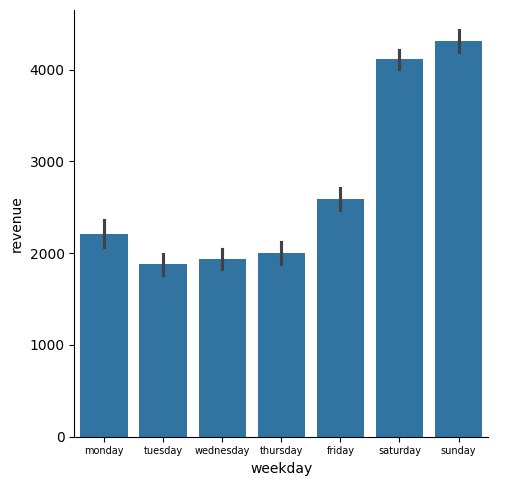

In [5]:
plot_avg_revenue_per_weekday(df)

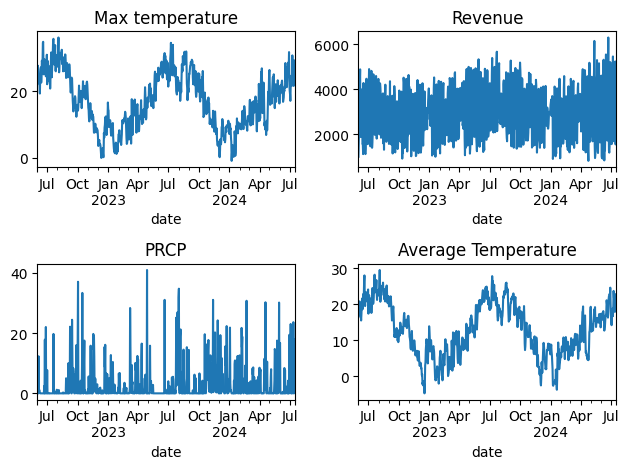

In [6]:
plot_data(df)

/Users/jonasfischer/Library/CloudStorage/OneDrive-Persönlich/Projekte/Restaurant-Revenue-Forecasting/src/demos.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), fontsize=7)


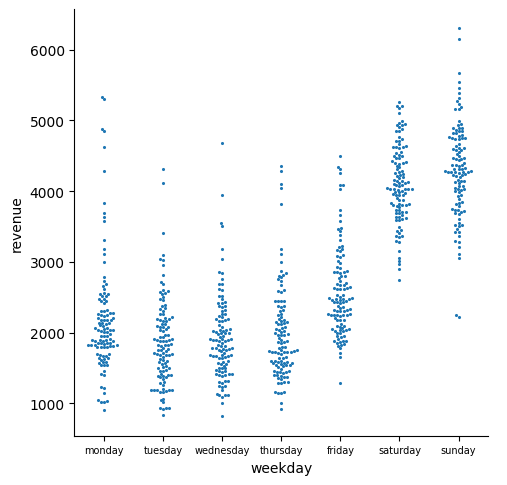

In [7]:
plot_revenue_per_weekday(df)

**XGBoost Random Search**

In [78]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

X_train = train_df.drop('revenue', axis=1)
X_test = test_df.drop('revenue', axis=1)
X_test = X_test.drop("weekday", axis=1)
Y_train = train_df['revenue']
Y_test = test_df['revenue']

In [104]:
# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 8),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200),
    'colsample_bytree': (0.1, 1)
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=200, cv=5, scoring='neg_mean_absolute_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, Y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 1, 'learning_rate': np.float64(0.1067508886363264), 'max_depth': 5, 'n_estimators': 77, 'subsample': np.float64(0.910975602038748)}
Best score:  -373.68497806672127


In [105]:
params = random_search.best_params_

xgb_model = xgb.XGBRegressor(learning_rate = params['learning_rate'],
                           n_estimators  = params['n_estimators'],
                           max_depth     = params['max_depth'],
                           subsample    = params['subsample'],
                           colsample_bytree = params['colsample_bytree'],
                           eval_metric='rmsle')
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmsle', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None,
             learning_rate=np.float64(0.1067508886363264), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=77, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [107]:
predictions = xgb_model.predict(X_test)

In [108]:
print(f'MAPE: {mean_absolute_percentage_error(Y_test, predictions)}')
print(f'MAE {mean_absolute_error(Y_test, predictions)}')

MAPE: 0.20368002045469352
MAE 420.58460333408453


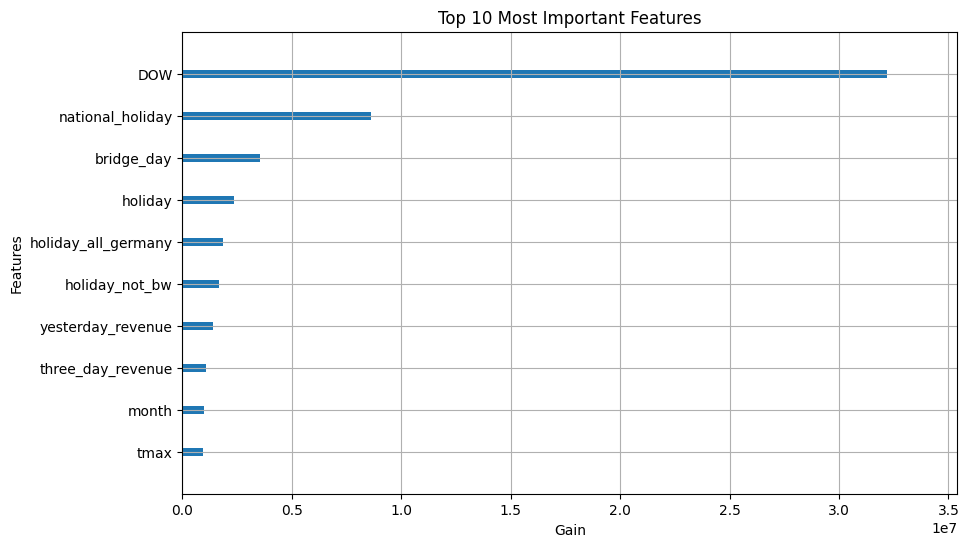

In [91]:
top_n = 10 
# Create feature names
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgb_model, ax=ax, importance_type='gain',
                    max_num_features=top_n, show_values=False)
# plt.yticks(range(top_n), xgb_model.feature_names[:top_n])
plt.xlabel('Gain')
plt.title(f'Top {top_n} Most Important Features')
plt.show()

**XGBoost Bayesian Optimization**

In [109]:
from bayes_opt import BayesianOptimization

In [149]:
# Define the objective function for Bayesian optimization
def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree, n_estimators):
    params = {'objective': 'reg:squarederror',
              'max_depth': int(max_depth),
              'learning_rate': learning_rate,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree}
    dtrain = xgb.DMatrix(X_train, label=Y_train)
    cv_result = xgb.cv(params, dtrain, num_boost_round=int(n_estimators), early_stopping_rounds=10, nfold=5, metrics='error')
    return -cv_result['test-error-mean'].iloc[-1]

In [147]:
pbounds = {'max_depth': (3, 9),
           'learning_rate': (0.01, 0.5),
           'subsample': (0.1, 1),
           'colsample_bytree': (0.1, 1),
           'n_estimators': (30,500)}

In [150]:
print('Performing hyperparameter tuning using Bayesian optimization...')
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=1)
optimizer.maximize(init_points=5, n_iter=20)

Performing hyperparameter tuning using Bayesian optimization...
|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 2.705e+03 | 0.4753    | 0.363     | 3.001     | 172.1     | 0.2321    |
| 2         | 2.705e+03 | 0.1831    | 0.1013    | 5.073     | 216.5     | 0.5849    |
| 3         | 2.705e+03 | 0.4773    | 0.3458    | 4.227     | 442.7     | 0.1246    |
| 4         | 2.705e+03 | 0.7034    | 0.2145    | 6.352     | 95.98     | 0.2783    |
| 5         | 2.705e+03 | 0.8207    | 0.4844    | 4.881     | 355.4     | 0.8888    |
| 6         | 2.705e+03 | 0.955     | 0.46      | 8.614     | 499.9     | 0.9631    |
| 7         | 2.705e+03 | 0.3563    | 0.4692    | 8.821     | 30.15     | 0.5733    |
| 8         | 2.705e+03 | 0.3084    | 0.4283    | 8.752     | 499.8     | 0.2225    |
| 9         | 2.705e+03 | 0.4939    | 0.3994    | 8.695     | 30.38     | 0.

In [151]:
params2 = {'objective': 'binary:logistic',
          'max_depth': int(optimizer.max['params']['max_depth']),
          'learning_rate': optimizer.max['params']['learning_rate'],
          'subsample': optimizer.max['params']['subsample'],
          'colsample_bytree': optimizer.max['params']['colsample_bytree'],
          'n_estimators': optimizer.max['params']['n_estimators']
          }

print(params2) 

{'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': np.float64(0.36295900178665746), 'subsample': np.float64(0.23208030173540176), 'colsample_bytree': np.float64(0.47531980423231657), 'n_estimators': np.float64(172.0963091369647)}


In [152]:
xgb_model_bo = xgb.XGBRegressor(learning_rate = params2['learning_rate'],
                           max_depth     = params2['max_depth'],
                           subsample    = params2['subsample'],
                           colsample_bytree = params2['colsample_bytree'])
xgb_model_bo.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.47531980423231657), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.36295900178665746), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [157]:
predictions_bo = xgb_model.predict(X_test)

In [158]:
print(f'MAPE: {mean_absolute_percentage_error(Y_test, predictions_bo)}')
print(f'MAE {mean_absolute_error(Y_test, predictions_bo)}')

MAPE: 0.20368002045469352
MAE 420.58460333408453
